# XGBoost and SHAP API Demonstration

## Understanding the building blocks

This notebook is a technical deep dive into the APIs and the project structure behind a credit scoring pipeline. Before you run the full system in `SHAP_Credit.example.ipynb`, we will first learn how XGBoost and SHAP work. We will also see how the `credit_scoring_shap` package is organized.

### What we will learn
- XGBoost basics using a small toy dataset
- SHAP TreeExplainer usage and core plots
- The German Credit dataset and the preprocessing pipeline
- Project code structure for data, modeling, evaluation, and explanation
- How to extend and customize the pipeline


This notebook is here to make the core pieces feel normal before you run the full pipeline.

## Section 1: Introduction to XGBoost
# Getting Started with XGBoost

XGBoost, which stands for eXtreme Gradient Boosting, is one of the most popular machine learning libraries out there. If you've ever competed in a Kaggle competition or worked on a real-world prediction problem with tabular data, you've probably heard of it.

## What makes XGBoost special?

Think of XGBoost as building a team of experts. Each expert (a decision tree) is pretty weak on their own, but when you combine hundreds of them, each one learning from the mistakes of the previous ones, you get something really powerful.

Here's what makes it stand out:
- It's fast. Really fast. The library is optimized to use all your CPU cores.
- It handles messy data well. Missing values? No problem.
- It has built-in regularization to prevent overfitting.
- It works incredibly well on structured data like spreadsheets and databases.

## How does gradient boosting work?

Imagine you're trying to predict house prices. Your first model makes a guess, but it's not perfect. Instead of starting over, you build a second model that focuses on fixing the errors from the first one. Then a third model fixes what the second one missed. And so on.

Each new model is added to the ensemble, and the final prediction is the sum of all these models. The "gradient" part means we're using calculus to figure out exactly what errors to fix in each step.

## The key parameters you'll see

When you create an XGBoost model, there are a few important settings:

**n_estimators** - How many trees to build. More trees can mean better performance, but also longer training time.

**learning_rate** - How much each tree contributes. Lower values (like 0.01) mean more conservative learning and often better results, but you'll need more trees.

**max_depth** - How deep each tree can grow. Deeper trees can capture more complex patterns but risk overfitting.

**subsample** and **colsample_bytree** - These control randomness by using only a fraction of your data or features for each tree. This helps prevent overfitting.

## When should you use XGBoost?

XGBoost shines when you have:
- Structured data (think rows and columns, not images or text)
- A classification or regression problem
- Need for both accuracy and interpretability
- Data with missing values

It's not the best choice for:
- Image recognition (use deep learning instead)
- Natural language processing (transformers work better)
- When you need instant predictions (it can be slower than simpler models)

Let's see it in action.

In [1]:
# Setup: imports and paths

import os
import sys

sys.path.append("/workspace")
sys.path.append("/workspace/credit_scoring_shap")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image, display

import xgboost as xgb
import shap

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Project-level API imports
from credit_scoring_shap.config import TrainingConfig
from credit_scoring_shap.data import load_raw_data, load_and_preprocess
from credit_scoring_shap.modeling import build_model, train_model, evaluate_model
from credit_scoring_shap.evaluation import (
    plot_confusion_matrix,
    plot_roc_curves,
    save_metrics_text,
)
from credit_scoring_shap.explain import (
    build_shap_explainer,
    plot_global_shap_summary,
    plot_shap_dependence_for_top_feature,
)
from credit_scoring_shap.sensitivity import run_sensitivity_for_instance

# Plot defaults
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Global configuration

cfg = TrainingConfig()
reports_dir = cfg.ensure_reports_dir()
cfg

TrainingConfig(data=DataConfig(target_col='Risk', test_size=0.2, random_state=42), model=ModelConfig(learning_rate=0.05, max_depth=4, n_estimators=400, subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, reg_alpha=0.0), reports_dir='reports')

### Output explanation

This cell prints the `TrainingConfig` object, typically something like:

- `DataConfig` with:
  - Path to the German Credit dataset,
  - Target column name,
  - Train/test split sizes, random seed, etc.
- `ModelConfig` with:
  - XGBoost hyperparameters (depth, learning rate, n_estimators, etc.).
- Paths for:
  - `reports_dir`,
  - Possibly model artifacts.

## Section 2: XGBoost on toy data

## Building your first model

Let's start simple. We'll create some fake data where we know the patterns, train a model, and see how well it works. This is a great way to learn because everything is under our control.

We're going to:
1. Generate a toy dataset with 10 features
2. Split it into training and test sets
3. See what we're working with

Nothing fancy yet, just getting our hands dirty with the basics.

### XGBoost hyperparameters explained

Before training, we explain the parameters we set:

n_estimators=200             # Number of trees in the ensemble
learning_rate=0.1            # Step size for each tree contribution
max_depth=4                  # Tree depth limit
subsample=0.9                # Fraction of rows used per tree
colsample_bytree=0.9         # Fraction of columns used per tree
objective="binary:logistic"  # Binary classification with logistic loss
eval_metric="logloss"        # Training metric
tree_method="hist"           # Histogram based training method
random_state=42              # Reproducibility

Key concepts:

Boosting:

    Trees are built one after another.

    Each new tree focuses on errors made by earlier trees.

    The final prediction is the sum of contributions from all trees.

Learning rate:

    Lower learning rate is more conservative and can reduce overfitting.

    Lower learning rate usually needs more trees.

    A value like 0.1 is more aggressive than 0.05 or 0.01.

Max depth:

    Deeper trees can learn more complex patterns.

    Deeper trees also overfit more easily.

    Depth 4 means each tree can ask up to 4 yes or no split questions.

Subsampling:

    subsample and colsample_bytree add randomness.

    This helps regularize the model.

    It can improve generalization.

Simple analogy:

    Think of the model as a large group of small trees.

    Each tree is weak by itself.

    Together they become strong.

In [3]:
# Create a small synthetic dataset

X_toy, y_toy = make_classification(
    n_samples=500,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    n_clusters_per_class=2,
    random_state=42,
)

X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(
    X_toy,
    y_toy,
    test_size=0.2,
    random_state=42,
    stratify=y_toy,
)

X_train_toy.shape, X_test_toy.shape


((400, 10), (100, 10))

In [4]:
# Define a native XGBoost classifier

xgb_native = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    n_jobs=-1,
    random_state=42,
)

xgb_native


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

### Output explanation

The notebook prints the **model configuration**, not training results.  
You should see a long `XGBClassifier(...)` repr listing all hyperparameters.

**Beginner Tips**

- This object is just a **recipe** for the model; it has not learned anything yet.
- Hyperparameters like `max_depth`, `learning_rate`, `n_estimators` control:
  - How complex each tree is,
  - How big each update is,
  - How many trees we build.

**Advanced Reader Notes**

- `tree_method="hist"` is a modern histogram-based algorithm, faster on larger datasets.
- `subsample` and `colsample_bytree` add stochasticity and regularization.
- `eval_metric="logloss"` is used during training evaluation but we’ll focus on **AUC** externally.


In [5]:
# Fit and evaluate AUC on the toy data

xgb_native.fit(X_train_toy, y_train_toy)
y_proba_toy = xgb_native.predict_proba(X_test_toy)[:, 1]
auc_toy = roc_auc_score(y_test_toy, y_proba_toy)

print(f"Native XGBoost on toy data - AUC: {auc_toy:.4f}")

Native XGBoost on toy data - AUC: 0.9672


### Output explanation

Interpretation:

AUC ≈ 0.97 ⇒ the model very effectively ranks positive examples above negatives.

Values:

0.5 = random guessing,

1.0 = perfect ranking.

**Beginner Tips**

AUC focuses on how well the model ranks; it does not depend on a specific classification threshold.

The predict_proba method gives class probabilities; we select [:, 1] for the positive class.

**Advanced Reader Notes**

On toy data, such high AUC is expected; on real-world credit data, AUC values are more modest.

For imbalanced data, AUC is often preferred over accuracy because it is threshold-independent.


In [6]:
importances = xgb_native.feature_importances_
feature_names_toy = [f"x{i}" for i in range(X_toy.shape[1])]

sorted_idx = np.argsort(importances)[::-1]

print("Top 5 features by gain-based importance:")
for idx in sorted_idx[:5]:
    print(f"{feature_names_toy[idx]}: {importances[idx]:.3f}")


Top 5 features by gain-based importance:
x0: 0.267
x5: 0.153
x1: 0.138
x8: 0.110
x2: 0.101


**Meaning:**

x0 is the most important feature according to XGBoost’s internal metric (e.g. gain).

Values are relative scores; they do not sum to 1 necessarily.

**What this tells you**
It tells you which features the model used a lot.

**What this does not tell you**
It does not tell:
- Direction: does a high value increase or decrease the prediction
- Magnitude: how much the prediction changes
- Variability: does the effect change across samples
- Interactions: does the effect depend on other features

**Beginner Tips**

 - Feature importance here tells you which features the model uses most, but not:

  - Whether high values of a feature increase or decrease risk.

 - This is one reason we need SHAP, which gives signed contributions.

**Advanced Reader Notes**

Gain-based importances can be:

 - Biased towards features with more levels,
 
 - Distorted by multicollinearity.

This is why we use SHAP next. SHAP’s game-theoretic foundations provide more reliable attributions.

## Section 3: Native SHAP TreeExplainer on the toy model

### What SHAP is
SHAP stands for SHapley Additive exPlanations.
It is based on Shapley values from cooperative game theory.

Think of each feature as a player.
The prediction is the game outcome.
SHAP asks how much each feature contributed.

Now we will try to look at how shap is used with Tree models to better understand SHAP
### What TreeExplainer does
For tree models, SHAP provides `shap.TreeExplainer`. it attributes how much each input feature contributed to a single prediction (values that sum to the model output minus the expected value).

### API calls used in this section
- `explainer_toy = shap.TreeExplainer(xgb_native)`
- `shap_values_toy = explainer_toy.shap_values(background_toy)`

Binary classification detail:
For binary classification, SHAP values can be returned as:
- a list `[class0, class1]`, or
- a single array for the positive class

This notebook checks the type. If it is a list, it selects index 1.

### Why we choose a background set
SHAP uses a baseline called the expected value.
The choice of background affects that baseline.
Here we use `background_toy = X_train_toy[:200]`.


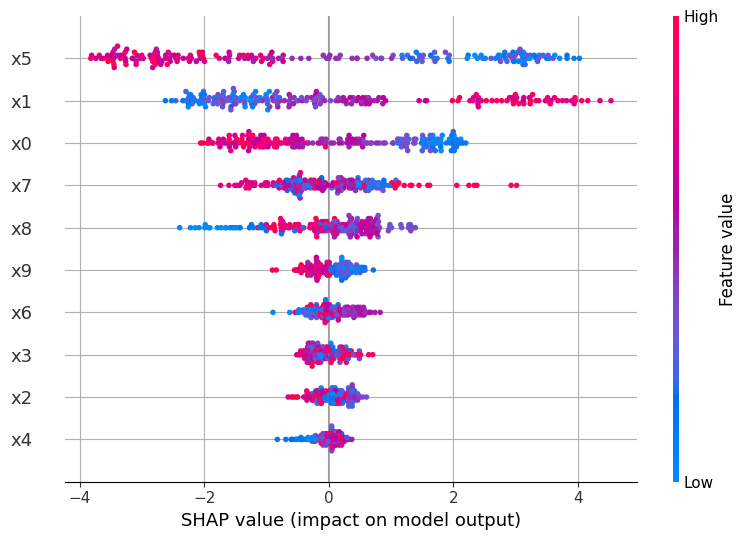

In [7]:
# SHAP summary plot on the toy model

shap.initjs()

# Use a subset of training data as "background"
background_toy = X_train_toy[:200]

explainer_toy = shap.TreeExplainer(xgb_native)
shap_values_toy = explainer_toy.shap_values(background_toy)

# For binary classification, shap_values can be a list [class0, class1]
if isinstance(shap_values_toy, list):
    shap_values_toy = shap_values_toy[1]

feature_names_toy = [f"x{i}" for i in range(X_toy.shape[1])]

shap.summary_plot(
    shap_values_toy,
    background_toy,
    feature_names=feature_names_toy,
    max_display=10,
    show=False,
)

plt.tight_layout()
toy_summary_path = os.path.join(reports_dir, "api_toy_shap_summary.png")
plt.savefig(toy_summary_path, bbox_inches="tight")
plt.close()

display(Image(filename=toy_summary_path, width=500))


### How to read the plot

You should see a **SHAP summary plot** image with:

- **Y-axis**: features (`x0`, `x1`, …).
- **X-axis**: SHAP value (impact on model output).
- **Dots**:
  - Each dot = one sample’s contribution for that feature.
  - Color (blue → red) = low to high feature value.

Interpretation:

- Features at the top with wide spread (large |SHAP|) are **globally important**.
- Color + position show direction:
  - Red dots on positive SHAP side ⇒ high feature values push towards the positive class.
  - Blue dots on negative side ⇒ low values push towards the negative class (or vice-versa).

**Beginner Tips**

- Read SHAP values as **“how much this feature changed the prediction compared to a baseline”**.
- Focus first on which features appear at the top: they matter most overall.

**Advanced Reader Notes**

- SHAP summary combines global importance and distribution in one plot.
- The choice of background (`background_toy`) affects the SHAP baseline; in complex setups you may want:
  - Stratified background,
  - Or domain-informed sampling.


The toy dataset is helpful to get comfortable with the APIs, but real credit data is messier.

Next, we will:

- Switch to the **UCI German Credit** dataset.
- Use the project’s data loading and preprocessing API.
- See how engineered features and class balance look in practice.

## Project Modeling API


The modeling API wraps XGBoost into a small set of functions:

- `build_model(cfg.model)`  
  → build an `XGBClassifier` from configuration.

- `train_model(model, X_train, y_train)`  
  → fit the model, return the trained object.

- `evaluate_model(model, X_test, y_test, threshold=0.5)`  
  → compute:
  - AUC,
  - Confusion matrix,
  - Classification report,
  - And return predictions.

In the **example notebook**, these functions are used to run the full experiment.  
Here we focus on **understanding the API**.


In [8]:
# Build an XGBoost model from configuration

model = build_model(cfg.model)
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

### Discussion 

**Credit-Scoring Model Configuration**

The printed `XGBClassifier` shows the exact hyperparameters used in this
project:

- **Shallow trees** (`max_depth=4`) with **many estimators** (`n_estimators=400`)
  give a smooth decision function that often generalizes well to tabular data.
- A **small learning rate** (`learning_rate=0.05`) encourages gradual learning
  and reduces overfitting.
- Subsampling (`subsample=0.9`, `colsample_bytree=0.9`) introduces randomness,
  acting as regularization.
- `eval_metric='logloss'` and `objective='binary:logistic'` tell XGBoost to
  optimize a probabilistic binary classification loss.

For beginners:

> You can think of this model as a large “committee” of shallow decision trees.
> Each tree is weak on its own, but together they form a powerful predictor of
> credit risk.

For advanced readers:

- These settings are deliberately conservative: we’re aiming for a **sensible
  baseline** that is easy to interpret, not an aggressively tuned Kaggle
  solution.
- Keeping the configuration in a `ModelConfig` dataclass makes it simple to
  experiment with alternative setups (e.g. deeper trees or fewer estimators)
  while still documenting the baseline clearly.


In [11]:
# Train and evaluate the model (minimal example)

model = train_model(model, X_train_toy, y_train_toy)

metrics, y_proba, y_pred = evaluate_model(
    model,
    X_test_toy,
    y_test_toy,
    threshold=0.5,
)

print("AUC:", metrics.get("auc"))
print("Confusion matrix:\n", metrics.get("confusion_matrix"))
print("\nClassification report:\n", metrics.get("classification_report"))


[02:43:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



AUC: 0.968
Confusion matrix:
 [[47  3]
 [10 40]]

Classification report:
               precision    recall  f1-score   support

        Good       0.82      0.94      0.88        50
         Bad       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



**Beginner Tips**

 - AUC is usually the main metric for ranking models.

 - F1 / precision / recall depend on the threshold (threshold=0.5 here). In production, you may choose a different threshold based on business needs.

**Advanced Reader Notes**

 - The evaluation function centralizes metric computation:

    - Good for logging and experiment tracking.

 - You can extend it with:

    - Calibration metrics (Brier score),

    - Stability metrics,

    - Fairness metrics for different subgroups.

In [10]:
print("=== evaluate_model ===")
print(evaluate_model.__doc__ or "No docstring.")

print("\n=== plot_confusion_matrix ===")
print(plot_confusion_matrix.__doc__ or "No docstring.")

print("\n=== plot_roc_curves ===")
print(plot_roc_curves.__doc__ or "No docstring.")


=== evaluate_model ===

    Compute AUC, confusion matrix, classification report and return predictions.

    Conventions:
    - y = 1 means Bad (default risk, positive class)
    - y = 0 means Good
    - y_proba = P(Bad)
    

=== plot_confusion_matrix ===

    Save a simple confusion-matrix heatmap.
    

=== plot_roc_curves ===

    Save ROC and PR curves side-by-side.
    


### Discussion 

**Credit-Scoring Model Configuration**

The printed `XGBClassifier` shows the exact hyperparameters used in this
project:

- **Shallow trees** (`max_depth=4`) with **many estimators** (`n_estimators=400`)
  give a smooth decision function that often generalizes well to tabular data.
- A **small learning rate** (`learning_rate=0.05`) encourages gradual learning
  and reduces overfitting.
- Subsampling (`subsample=0.9`, `colsample_bytree=0.9`) introduces randomness,
  acting as regularization.
- `eval_metric='logloss'` and `objective='binary:logistic'` tell XGBoost to
  optimize a probabilistic binary classification loss.

For beginners:

> You can think of this model as a large “committee” of shallow decision trees.
> Each tree is weak on its own, but together they form a powerful predictor of
> credit risk.

For advanced readers:

- These settings are deliberately conservative: we’re aiming for a **sensible
  baseline** that is easy to interpret, not an aggressively tuned Kaggle
  solution.
- Keeping the configuration in a `ModelConfig` dataclass makes it simple to
  experiment with alternative setups (e.g. deeper trees or fewer estimators)
  while still documenting the baseline clearly.


## Explainability and sensitivity (project API)

The explainability module provides SHAP helpers:

- `build_shap_explainer(model, X_background, feature_names, reports_dir, ...)`
- `plot_global_shap_summary(shap_values, X, feature_names, reports_dir, ...)`
- `plot_shap_dependence_for_top_feature(...)`

The sensitivity module provides:

- `run_sensitivity_for_instance(model, explainer, X, y, idx, feature_names, top_n, reports_dir, ...)`  
  → For one borrower, vary top features and see how predicted probability responds.

In this notebook, we **inspect** these APIs;  
the **example notebook** will run them in a full storytelling flow.


### Typical usage pattern (for the example notebook)

In the example notebook, you will typically see code like:

```python
# 1. Train and evaluate
model = build_model(cfg.model)
model = train_model(model, X_train, y_train)
metrics, y_proba, y_pred = evaluate_model(model, X_test, y_test)

# 2. Build SHAP explainer
explainer, shap_values_background = build_shap_explainer(
    model=model,
    X_background=X_train,
    feature_names=feature_names,
    reports_dir=cfg.reports_dir,
)

# 3. Global SHAP plots
plot_global_shap_summary(
    shap_values=shap_values_background,
    X=X_train,
    feature_names=feature_names,
    reports_dir=cfg.reports_dir,
)

plot_shap_dependence_for_top_feature(
    shap_values=shap_values_background,
    X=X_train,
    feature_names=feature_names,
    reports_dir=cfg.reports_dir,
)

# 4. Local sensitivity
sens_results = run_sensitivity_for_instance(
    model=model,
    explainer=explainer,
    X=X_test,
    y=y_test,
    idx=0,
    feature_names=feature_names,
    top_n=3,
    reports_dir=cfg.reports_dir,
)


**Beginner Tips**

- At a minimum, remember the pattern:

  1. Train model →  
  2. `build_shap_explainer(...)` →  
  3. `plot_global_shap_summary(...)` →  
  4. `run_sensitivity_for_instance(...)` for a particular borrower.

**Advanced Reader Notes**

- You could wrap these calls in a CLI or REST API:
  - E.g., `/explain_global`, `/explain_local`, `/sensitivity`.
- For high-dimensional data, consider:
  - Limiting `top_n` in sensitivity,
  - Caching SHAP computations.

## Developer appendix. A project module overview

For developers extending the project, the modules are:

- `config.py`  
  - Defines `TrainingConfig`, `DataConfig`, `ModelConfig`, etc.
  - Single source of truth for paths and hyperparameters.

- `data.py`  
  - `load_raw_data` → returns the raw German Credit DataFrame.
  - `load_and_preprocess` → returns encoded train/test, pipeline, and feature names.

- `modeling.py`  
  - `build_model` → constructs XGBoost model from `ModelConfig`.
  - `train_model` → fits model.
  - Possibly helpers for saving / loading models.

- `evaluation.py`  
  - `evaluate_model` → AUC, confusion matrix, classification report.
  - `plot_confusion_matrix`, `plot_roc_curves`, `save_metrics_text` → plots and reports.

- `explain.py`  
  - SHAP-specific helpers to build explainers and plots.

- `sensitivity.py`  
  - Local sensitivity analysis based on SHAP values.



## Where to go next

to wrap up the workflow:

1. Read this API notebook to understand:
   - Native XGBoost and SHAP usage on a toy problem.
   - What each project helper does and what it returns.

2. Run the Full Pipeline
Head to `shap_example.ipynb` to see these APIs in action.